# Extract the Diabetes Mention from MIMIC-III dataset documents

In this notebook I will be developing a python script for finding the mention of Diabetes in text documents. This notebook is going to go through the actual MIMIC documents that I have selected to be my training documents. 


First step, import PyConText and define the functions (taken from the PyConText github page and modified with help from Jeff Ferraro) so that I can run the actual text parsing. 

In [1]:
import pyConTextNLP.pyConText as pyConText
# itemData has been rewritten, so that it can take relative local path, where you can redirect it to your customized yml files later
import os
import itemData
import re
import glob
import pandas as pd
from xml.etree import ElementTree
import math

# Set distance for each modification type
distance_negation = 40
distance_other = 40
distance_hypothetical = 70
distance_type = 70

In [2]:
os.listdir('Yaml_Files')

['A1c_modifiers.yml',
 'Diabetes_modifiers.tab_delimited.txt',
 'Diabetes_targets.yml',
 'A1c_targets.yml',
 'Diabetes_modifiers.yml']

In [3]:
my_targets=itemData.get_items('Yaml_Files/Diabetes_targets.yml')
my_modifiers=itemData.get_items('Yaml_Files/Diabetes_modifiers.yml')

The functions *markup_sentence* and *markup_doc* were both ones that we went over in the NLP lab.

In [4]:
## This one is the same, it just doesn't split it into sentences. 
def markup_sentence(s, modifiers, targets, prune_inactive=True):
    """
    """
    markup = pyConText.ConTextMarkup()
    markup.setRawText(s)
    markup.cleanText()
    markup.markItems(my_modifiers, mode="modifier")
    markup.markItems(my_targets, mode="target")
    markup.pruneMarks()
    markup.dropMarks('Exclusion')
    # apply modifiers to any targets within the modifiers scope
    markup.applyModifiers()
    markup.pruneSelfModifyingRelationships()
    if prune_inactive:
        markup.dropInactiveModifiers()
    return markup

def markup_doc(doc_text:str)->pyConText.ConTextDocument:
    rslts=[]
    context = pyConText.ConTextDocument()
    def markup_doc(doc_text:str)->pyConText.ConTextDocument:
        rslts=[]
        context = pyConText.ConTextDocument()
#         for s in doc_text.split('.'):
#             m = markup_sentence(s, modifiers=my_modifiers, targets=my_targets)
#             rslts.append(m)

    #for s in doc_text.split('.'):
    m = markup_sentence(doc_text, modifiers=my_modifiers, targets=my_targets)
    rslts.append(m)

    for r in rslts:
        context.addMarkup(r)
    return context

def get_output(something):
    context=markup_doc(something)
    output = context.getDocumentGraph()
    return output

Ok, I have figured out how to get the pieces of a node that I can use for every node. I can put these into lists and then add the lists into a dataframe, then transpose the dataframe and I can have something to work with. The next step is going to be reading in the documents and figuring out how to apply 

In [5]:
os.listdir('Text_Files/')

['.DS_Store',
 'Training_Dataset',
 'test_files.txt',
 'Testing_Dataset',
 'list_of_Files.txt']

In [6]:
import glob
list_of_files = glob.glob("Text_Files/Training_Dataset/*.txt")
print(len(list_of_files))
list_of_files[0:3]
#len(list_of_files)

75


['Text_Files/Training_Dataset/591025.txt',
 'Text_Files/Training_Dataset/460590.txt',
 'Text_Files/Training_Dataset/26356.txt']

In [7]:
replaced_list = [w.replace('Text_Files/Training_Dataset/', '') for w in list_of_files] 
list_of_identifiers = [i.replace(".txt", "") for i in replaced_list] 
print(list_of_identifiers[0:10])

['591025', '460590', '26356', '19164', '739925', '949239', '316110', '717600', '649768', '1427703']


In [8]:
list_of_text = [] 
for file in list_of_files:
    text_file = open(file, 'r')
    list_of_text.append(text_file.read()) # Not Readlines
    text_file.close()

In [9]:
print(list_of_text[0])

CVICU
   HPI:
   HD3
   readmit left pleural effusion
   66M s/p CABGx3(LIMA-LAD,SVG-OM,SVG-PLB) [**5-14**]
   EF:60% Wt:104kg Cr:1.1 HgA1c:6.2
   PMH:HTN,GERD,peripheral neuropathy, CAD, chronic diastolic HF
   [**Last Name (un) **]: HCTZ 25', lopressor 75''', lipitor 10', Naproxen 500mg''prn,
   omeprazole 20mg', MVI, colace 100''
   Current medications:
   Albuterol Inhaler, Albuterol 0.083% Neb Soln, Argatroban, Aspirin,
   Atorvastatin, Docusate Sodium, Furosemide, Metoprolol Tartrate,
   Multivitamins, Naproxen, Omeprazole, Piperacillin-Tazobactam Na,
   Potassium Chloride, Vancomycin
   24 Hour Events:
   Transferred to ICU for respiratory distress, resolved with oxygen
   Started on heparin for pulmonary embolsm
   Allergies:
   No Known Drug Allergies
   Last dose of Antibiotics:
   Vancomycin - [**2796-5-29**] 12:07 AM
   Piperacillin/Tazobactam (Zosyn) - [**2796-5-29**] 04:06 AM
   Infusions:
   Heparin Sodium - 1,300 units/hour
   Other ICU medications:
   Other medications

In [10]:
text_df = pd.DataFrame({"Identifier" : list_of_identifiers, "Text": list_of_text}) 
text_df.head()

,Identifier,Text
0,591025,CVICU\n HPI:\n HD3\n readmit left pleura...
1,460590,TITLE:\n Chief Complaint:\n 24 Hour Events...
2,26356,Admission Date: [**3367-2-4**] D...
3,19164,Admission Date: [**2807-7-8**] Discharge ...
4,739925,[**2945-9-9**] 3:04 PM\n CHEST (PA & LAT) ...


In [11]:
i = 0
output_array = []
while i < len(text_df):
    raw_text = text_df["Text"][i]
    remove_MIMIC_comments = re.sub(r"\[\*\*.*?\*\*\]", "", raw_text)
    remove_times = re.sub(r"\d{1,2}:\d{2}\s?P?A?\.?M\.?", "", remove_MIMIC_comments)
    cleaned_text = re.sub(r"\s{2,}", r" ", remove_times)
    
    context=markup_doc(cleaned_text)
    root = ElementTree.fromstring(context.getDocumentGraph().getXML())
    for node in root.findall('.//node'):
        phrase = node.find('.//phrase').text
        #tmp1 =  re.sub(r"[A|a]1[C|c]", "", phrase)
        #A1c_Value = re.sub(r"[^\d{1,2}\.?\d{0,1}]", "", tmp1)
        #A1c_Flag = get_a1c_flag(A1c_Value)
        literal = node.find('.//literal').text
        Start = node.find('.//spanStart').text
        Stop = node.find('.//spanStop').text
        Node_ID = node.find('.//id').text
        category = node.find('./category').text #This picks up target or modifier, not useful
        try:
            modified_by = node.find('.//modifyingNode').text
        except:
            modified_by = "None"
        try:
            modifying_category = node.find('.//modifyingCategory').text
        except:
            modifying_category = "None"
        try:
            node_modified = node.find('.//modifiedNode').text
        except:
            node_modified = "None"
        output_array.append([text_df["Identifier"][i], Start, Stop, phrase, literal, Node_ID,
                             modifying_category, modified_by, node_modified])
    i += 1
            
#output_array

In [12]:
# output_array

In [13]:
# raw_text = text_df["Text"][1]
# remove_MIMIC_comments = re.sub(r"\[\*\*.*?\*\*\]", "", raw_text)
# remove_times = re.sub(r"\d{1,2}:\d{2}\s?P?A?\.?M\.?", "", remove_MIMIC_comments)
# cleaned_text = re.sub(r"\s{2,}", r" ", remove_times)
    
# context=markup_doc(cleaned_text)
# root = ElementTree.fromstring(context.getDocumentGraph().getXML())
# for node in root.findall('.//node'):
#     phrase = node.find('.//phrase').text
#         #tmp1 =  re.sub(r"[A|a]1[C|c]", "", phrase)
#         #A1c_Value = re.sub(r"[^\d{1,2}\.?\d{0,1}]", "", tmp1)
#         #A1c_Flag = get_a1c_flag(A1c_Value)
#     literal = node.find('.//literal').text
#     Start = node.find('.//spanStart').text
#     Stop = node.find('.//spanStop').text
#     Node_ID = node.find('.//id').text
#     category = node.find('./category').text #This picks up target or modifier, not useful
#     try:
#         modified_by = node.find('.//modifyingNode').text
#     except:
#         modified_by = "None"
#     try:
#         modifying_category = node.find('.//modifyingCategory').text
#     except:
#         modifying_category = "None"
#     try:
#         node_modified = node.find('.//modifiedNode').text
#     except:
#         node_modified = "None"
#     output_array.append([text_df["Identifier"][1], Start, Stop, phrase, literal, Node_ID, modifying_category, modified_by, node_modified])

In [14]:
output_array
train_df = pd.DataFrame(output_array, columns=("Identifier", "Start", "Stop", "Phrase", "Annotation_Type", "Node_ID", "Modifying_Category", "Modified_By", "Node_Modified"))
train_df

,Identifier,Start,Stop,Phrase,Annotation_Type,Node_ID,Modifying_Category,Modified_By,Node_Modified
0,460590,102,110,negative,NOT,120976853485115922873781253680493253439,None,None,120977566538578551252819595576046277439
1,460590,1450,1452,DM,DM,120977566538578551252819595576046277439,['diabetes_in_other'],120974810983086305139158092117453591359,None
2,460590,1512,1514,no,NOT,120976917659927559427894704451093025599,None,None,120977566538578551252819595576046277439
3,460590,2451,2453,DM,DM,120977594268435431245337753316428895039,['diabetes_in_other'],120974810983086305139158092117453591359,None
4,460590,2806,2808,No,NOT,120976985003865696552581658963450811199,None,None,120977566538578551252819595576046277439
5,460590,2894,2896,No,NOT,120976994511245198264302170188724851519,None,None,120977566538578551252819595576046277439
6,460590,3184,3187,not,NOT,120977012733722576545099816703833428799,None,None,120977566538578551252819595576046277439
7,460590,3230,3232,No,NOT,120977020656538827971533576058228462399,None,None,120977566538578551252819595576046277439
8,460590,3709,3711,No,NOT,120977045217269207393478230056853066559,None,None,120977566538578551252819595576046277439
9,460590,3870,3872,No,NOT,120977057893775209675772245023885120319,None,None,120977566538578551252819595576046277439


In [15]:
# modifier_columns = train_df[train_df["Node_Modified"]!="None"]
# modifier_columns
modifier_columns = train_df[train_df["Node_Modified"]!="None"]
Diabetes_Results = train_df.drop(modifier_columns.index, axis = 0)
print(len(Diabetes_Results))
print(len(modifier_columns))

77
250


In [16]:
modifier_columns

,Identifier,Start,Stop,Phrase,Annotation_Type,Node_ID,Modifying_Category,Modified_By,Node_Modified
0,460590,102,110,negative,NOT,120976853485115922873781253680493253439,None,None,120977566538578551252819595576046277439
2,460590,1512,1514,no,NOT,120976917659927559427894704451093025599,None,None,120977566538578551252819595576046277439
4,460590,2806,2808,No,NOT,120976985003865696552581658963450811199,None,None,120977566538578551252819595576046277439
5,460590,2894,2896,No,NOT,120976994511245198264302170188724851519,None,None,120977566538578551252819595576046277439
6,460590,3184,3187,not,NOT,120977012733722576545099816703833428799,None,None,120977566538578551252819595576046277439
7,460590,3230,3232,No,NOT,120977020656538827971533576058228462399,None,None,120977566538578551252819595576046277439
8,460590,3709,3711,No,NOT,120977045217269207393478230056853066559,None,None,120977566538578551252819595576046277439
9,460590,3870,3872,No,NOT,120977057893775209675772245023885120319,None,None,120977566538578551252819595576046277439
10,460590,4044,4046,no,NOT,120977070570281211958066259990917174079,None,None,120977566538578551252819595576046277439
11,460590,4302,4310,negative,NOT,120977088000476965096220530570586247999,None,None,120977566538578551252819595576046277439


In [17]:
Diabetes_Results

,Identifier,Start,Stop,Phrase,Annotation_Type,Node_ID,Modifying_Category,Modified_By,Node_Modified
1,460590,1450,1452,DM,DM,120977566538578551252819595576046277439,['diabetes_in_other'],120974810983086305139158092117453591359,None
3,460590,2451,2453,DM,DM,120977594268435431245337753316428895039,['diabetes_in_other'],120974810983086305139158092117453591359,None
19,460590,5883,5891,Diabetes,DIABETES_OR_DIABETIC,120977504740611790126636272611765015359,['diabetes_in_other'],120974810983086305139158092117453591359,None
21,26356,563,568,NIDDM,NIDDM,120990466467999123772266576402039984959,['diabetes_in_other'],120986502683028535127456771398204674879,None
36,26356,5400,5405,NIDDM,NIDDM,120990706529331541993209484840209503039,['diabetes_in_other'],120986558142742295112493086878969910079,None
40,19164,139,147,diabetes,DIABETES_OR_DIABETIC,120998249842684525100791766159720993599,['diabetes_negated'],120997928968626342330224512306722132799,None
49,739925,190,192,DM,DM,121001533057739116214941642621022917439,['diabetes_negated'],121001434022535973384519650691084997439,None
50,739925,374,391,diabetes mellitus,DIABETES_OR_DIABETIC,121001502158755735651849981138882286399,['diabetes_negated'],121001434022535973384519650691084997439,None
54,316110,1432,1449,diabetes Mellitus,DIABETES_OR_DIABETIC,121006280409236970934050247774527050559,['diabetes_type_1'],121005406522604438598406590984754844479,None
55,316110,1451,1453,DM,DM,121006339038077231489660066997050299199,['diabetes_type_1'],121005406522604438598406590984754844479,None


In [18]:
node_locations = Diabetes_Results[["Start", "Stop", "Node_ID"]]
node_locations.head()

,Start,Stop,Node_ID
1,1450,1452,120977566538578551252819595576046277439
3,2451,2453,120977594268435431245337753316428895039
19,5883,5891,120977504740611790126636272611765015359
21,563,568,120990466467999123772266576402039984959
36,5400,5405,120990706529331541993209484840209503039


In [19]:
node_locations.rename(columns={"Start":"Node_Start", "Stop":"Node_Stop", "Node_ID":"Node_Modified"}, inplace = True)
node_locations.head()

/Users/david/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Node_Start,Node_Stop,Node_Modified
1,1450,1452,120977566538578551252819595576046277439
3,2451,2453,120977594268435431245337753316428895039
19,5883,5891,120977504740611790126636272611765015359
21,563,568,120990466467999123772266576402039984959
36,5400,5405,120990706529331541993209484840209503039


In [20]:
modifier_columns = pd.merge(modifier_columns, node_locations, on='Node_Modified') #, how='right'
modifier_columns = modifier_columns[pd.notnull(modifier_columns['Identifier'])] # Drop the ones that weren't modifier nodes
modifier_columns

,Identifier,Start,Stop,Phrase,Annotation_Type,Node_ID,Modifying_Category,Modified_By,Node_Modified,Node_Start,Node_Stop
0,460590,102,110,negative,NOT,120976853485115922873781253680493253439,None,None,120977566538578551252819595576046277439,1450,1452
1,460590,1512,1514,no,NOT,120976917659927559427894704451093025599,None,None,120977566538578551252819595576046277439,1450,1452
2,460590,2806,2808,No,NOT,120976985003865696552581658963450811199,None,None,120977566538578551252819595576046277439,1450,1452
3,460590,2894,2896,No,NOT,120976994511245198264302170188724851519,None,None,120977566538578551252819595576046277439,1450,1452
4,460590,3184,3187,not,NOT,120977012733722576545099816703833428799,None,None,120977566538578551252819595576046277439,1450,1452
5,460590,3230,3232,No,NOT,120977020656538827971533576058228462399,None,None,120977566538578551252819595576046277439,1450,1452
6,460590,3709,3711,No,NOT,120977045217269207393478230056853066559,None,None,120977566538578551252819595576046277439,1450,1452
7,460590,3870,3872,No,NOT,120977057893775209675772245023885120319,None,None,120977566538578551252819595576046277439,1450,1452
8,460590,4044,4046,no,NOT,120977070570281211958066259990917174079,None,None,120977566538578551252819595576046277439,1450,1452
9,460590,4302,4310,negative,NOT,120977088000476965096220530570586247999,None,None,120977566538578551252819595576046277439,1450,1452


In [21]:
modifier_columns["Distance"] = modifier_columns.apply(lambda x: max((int(x["Start"]) - int(x["Node_Stop"])), (int(x["Node_Start"])-int(x["Stop"]))), axis = 1)
modifier_columns

,Identifier,Start,Stop,Phrase,Annotation_Type,Node_ID,Modifying_Category,Modified_By,Node_Modified,Node_Start,Node_Stop,Distance
0,460590,102,110,negative,NOT,120976853485115922873781253680493253439,None,None,120977566538578551252819595576046277439,1450,1452,1340
1,460590,1512,1514,no,NOT,120976917659927559427894704451093025599,None,None,120977566538578551252819595576046277439,1450,1452,60
2,460590,2806,2808,No,NOT,120976985003865696552581658963450811199,None,None,120977566538578551252819595576046277439,1450,1452,1354
3,460590,2894,2896,No,NOT,120976994511245198264302170188724851519,None,None,120977566538578551252819595576046277439,1450,1452,1442
4,460590,3184,3187,not,NOT,120977012733722576545099816703833428799,None,None,120977566538578551252819595576046277439,1450,1452,1732
5,460590,3230,3232,No,NOT,120977020656538827971533576058228462399,None,None,120977566538578551252819595576046277439,1450,1452,1778
6,460590,3709,3711,No,NOT,120977045217269207393478230056853066559,None,None,120977566538578551252819595576046277439,1450,1452,2257
7,460590,3870,3872,No,NOT,120977057893775209675772245023885120319,None,None,120977566538578551252819595576046277439,1450,1452,2418
8,460590,4044,4046,no,NOT,120977070570281211958066259990917174079,None,None,120977566538578551252819595576046277439,1450,1452,2592
9,460590,4302,4310,negative,NOT,120977088000476965096220530570586247999,None,None,120977566538578551252819595576046277439,1450,1452,2850


In [22]:
modifier_columns.Annotation_Type.unique()

array([' NOT ', ' HYPOTHETICAL_DIABETES ', ' DIABETES_IN_OTHER ',
       ' DIABETES_TYPE_2 ', ' DIABETES_TYPE_1 ', ' DIABETES_GESTATIONAL ',
       ' DENIES '], dtype=object)

In [23]:
distance_negation = 40
distance_other = 60
distance_hypothetical = 100
distance_type = 100

def out_of_range(anno_type, distance):
    if anno_type == " NOT " or anno_type == " DENIES ":
        if distance <= distance_negation:
            return "Keep"
        else:
            return "Discard"
    elif anno_type == " DIABETES_IN_OTHER ":
        if distance <= distance_other:
            return "Keep"
        else:
            return "Discard"
    elif anno_type == " HYPOTHETICAL_DIABETES ":
        if distance <= distance_hypothetical:
            return "Keep"
        else: 
            return "Discard"
    elif anno_type == " DIABETES_TYPE_1 " or anno_type == " DIABETES_TYPE_2 " or anno_type == " DIABETES_GESTATIONAL " or anno_type == " DIABETES_INSIPIDUS ":
        if distance <= distance_type:
            return "Keep"
        else:
            return "Discard"
    else:
        return "Didn't Work"
        
#Merged_Manual_and_Machine["Category"] = Merged_Manual_and_Machine.apply(lambda x: get_category(x["HbA1c"], x["A1c_Value"]), axis = 1)

#modifier_columns
#modifier_columns["Distance"] = modifier_columns.apply(lambda x: max((int(x["Start"]) - int(x["Node_Stop"])), (int(x["Node_Start"])-int(x["Stop"]))), axis = 1)

In [24]:
modifier_columns["Keep"] = modifier_columns.apply(lambda x: out_of_range(x["Annotation_Type"], int(x["Distance"])), axis = 1)
modifier_columns

,Identifier,Start,Stop,Phrase,Annotation_Type,Node_ID,Modifying_Category,Modified_By,Node_Modified,Node_Start,Node_Stop,Distance,Keep
0,460590,102,110,negative,NOT,120976853485115922873781253680493253439,None,None,120977566538578551252819595576046277439,1450,1452,1340,Discard
1,460590,1512,1514,no,NOT,120976917659927559427894704451093025599,None,None,120977566538578551252819595576046277439,1450,1452,60,Discard
2,460590,2806,2808,No,NOT,120976985003865696552581658963450811199,None,None,120977566538578551252819595576046277439,1450,1452,1354,Discard
3,460590,2894,2896,No,NOT,120976994511245198264302170188724851519,None,None,120977566538578551252819595576046277439,1450,1452,1442,Discard
4,460590,3184,3187,not,NOT,120977012733722576545099816703833428799,None,None,120977566538578551252819595576046277439,1450,1452,1732,Discard
5,460590,3230,3232,No,NOT,120977020656538827971533576058228462399,None,None,120977566538578551252819595576046277439,1450,1452,1778,Discard
6,460590,3709,3711,No,NOT,120977045217269207393478230056853066559,None,None,120977566538578551252819595576046277439,1450,1452,2257,Discard
7,460590,3870,3872,No,NOT,120977057893775209675772245023885120319,None,None,120977566538578551252819595576046277439,1450,1452,2418,Discard
8,460590,4044,4046,no,NOT,120977070570281211958066259990917174079,None,None,120977566538578551252819595576046277439,1450,1452,2592,Discard
9,460590,4302,4310,negative,NOT,120977088000476965096220530570586247999,None,None,120977566538578551252819595576046277439,1450,1452,2850,Discard


In [25]:
modifier_columns = modifier_columns[modifier_columns["Keep"] == "Keep"]
modifier_columns

,Identifier,Start,Stop,Phrase,Annotation_Type,Node_ID,Modifying_Category,Modified_By,Node_Modified,Node_Start,Node_Stop,Distance,Keep
46,316110,1456,1463,Type II,DIABETES_TYPE_2,121005614100390225970971086069904724799,None,None,121006280409236970934050247774527050559,1432,1449,7,Keep
47,316110,1515,1522,Insulin,DIABETES_TYPE_1,121005406522604438598406590984754844479,None,None,121006280409236970934050247774527050559,1432,1449,66,Keep
62,649768,2145,2152,Type II,DIABETES_TYPE_2,121013554346837405542884711044607398719,None,None,121014171534223391662074564751980516159,2121,2138,7,Keep
63,649768,2171,2177,type 2,DIABETES_TYPE_2,121013563854216907254605222269881439039,None,None,121014171534223391662074564751980516159,2121,2138,33,Keep
71,697672,1089,1095,Type I,DIABETES_TYPE_1,121034574370634065014291654190071042879,None,None,121034914259451251208299930493617984319,1065,1082,7,Keep
80,24525,1060,1066,father,DIABETES_IN_OTHER,121059368031811278896098177833889190719,None,None,121061596720022805151914684225212142399,1086,1090,20,Keep
110,2040477,70,79,gestation,DIABETES_GESTATIONAL,121076779212805413626927735052415030079,None,None,121077019274137831847870643490584548159,90,98,11,Keep
111,2040477,81,84,Mom,DIABETES_IN_OTHER,121076586688370503964587382740615713599,None,None,121077019274137831847870643490584548159,90,98,6,Keep
118,5,353,363,noninsulin,DIABETES_TYPE_2,121079823158809211662778079010986939199,None,None,121081364938851739246787649376260477759,374,382,11,Keep
124,650735,95,101,type I,DIABETES_TYPE_1,121084351840578527012314925983188144959,None,None,121084908814561002290608208597159007039,92,94,1,Keep


Now I only have the modifiers that are within a specified distance (50 characters) of the node they modify.

In [26]:
def get_negated(value):
    if value == " DENIES ":
        return "Negated_Diabetes"
    elif value == " NOT ":
        return "Negated_Diabetes"
    else:
        return ""
    
def get_other(value):
    if value == " DIABETES_IN_OTHER ":
        return "Diabetes_in_other"
    else:
        return ""
    
def get_type(value):
    if value == " DIABETES_TYPE_1 ":
        return "Diabetes_Type_1"
    elif value == " DIABETES_TYPE_2 ":
        return "Diabetes_Type_2"
    elif value == " DIABETES_GESTATIONAL ":
        return "Diabetes_Gestational"
    elif value == " INSIPIDUS ":
        return "Diabetes_Insipidus"
    else:
        return "No_Type"
    
    
    

def get_hypothetical(value):
    if value == " HYPOTHETICAL_DIABETES ":
        return "Diabetes_Hypothetical"
    else:
        return ""

modifier_columns["Negated"] = modifier_columns["Annotation_Type"].apply(get_negated)
modifier_columns["Diabetes_in_other"] = modifier_columns["Annotation_Type"].apply(get_other)
modifier_columns["Type"] = modifier_columns["Annotation_Type"].apply(get_type)
modifier_columns["Hypothetical"] = modifier_columns["Annotation_Type"].apply(get_hypothetical)

/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [27]:
modifier_columns

,Identifier,Start,Stop,Phrase,Annotation_Type,Node_ID,Modifying_Category,Modified_By,Node_Modified,Node_Start,Node_Stop,Distance,Keep,Negated,Diabetes_in_other,Type,Hypothetical
46,316110,1456,1463,Type II,DIABETES_TYPE_2,121005614100390225970971086069904724799,None,None,121006280409236970934050247774527050559,1432,1449,7,Keep,,,Diabetes_Type_2,
47,316110,1515,1522,Insulin,DIABETES_TYPE_1,121005406522604438598406590984754844479,None,None,121006280409236970934050247774527050559,1432,1449,66,Keep,,,Diabetes_Type_1,
62,649768,2145,2152,Type II,DIABETES_TYPE_2,121013554346837405542884711044607398719,None,None,121014171534223391662074564751980516159,2121,2138,7,Keep,,,Diabetes_Type_2,
63,649768,2171,2177,type 2,DIABETES_TYPE_2,121013563854216907254605222269881439039,None,None,121014171534223391662074564751980516159,2121,2138,33,Keep,,,Diabetes_Type_2,
71,697672,1089,1095,Type I,DIABETES_TYPE_1,121034574370634065014291654190071042879,None,None,121034914259451251208299930493617984319,1065,1082,7,Keep,,,Diabetes_Type_1,
80,24525,1060,1066,father,DIABETES_IN_OTHER,121059368031811278896098177833889190719,None,None,121061596720022805151914684225212142399,1086,1090,20,Keep,,Diabetes_in_other,No_Type,
110,2040477,70,79,gestation,DIABETES_GESTATIONAL,121076779212805413626927735052415030079,None,None,121077019274137831847870643490584548159,90,98,11,Keep,,,Diabetes_Gestational,
111,2040477,81,84,Mom,DIABETES_IN_OTHER,121076586688370503964587382740615713599,None,None,121077019274137831847870643490584548159,90,98,6,Keep,,Diabetes_in_other,No_Type,
118,5,353,363,noninsulin,DIABETES_TYPE_2,121079823158809211662778079010986939199,None,None,121081364938851739246787649376260477759,374,382,11,Keep,,,Diabetes_Type_2,
124,650735,95,101,type I,DIABETES_TYPE_1,121084351840578527012314925983188144959,None,None,121084908814561002290608208597159007039,92,94,1,Keep,,,Diabetes_Type_1,


In [28]:
def max_len(s):
    return max(s, key=len)
def max_val(s):
    return max(s, key=int)
subset = modifier_columns.groupby("Node_Modified").agg({'Diabetes_in_other': max_len, "Hypothetical": max_len, "Negated": max_len, "Type": max_len, "Distance": max_val})


In [29]:
Diabetes_Results

,Identifier,Start,Stop,Phrase,Annotation_Type,Node_ID,Modifying_Category,Modified_By,Node_Modified
1,460590,1450,1452,DM,DM,120977566538578551252819595576046277439,['diabetes_in_other'],120974810983086305139158092117453591359,None
3,460590,2451,2453,DM,DM,120977594268435431245337753316428895039,['diabetes_in_other'],120974810983086305139158092117453591359,None
19,460590,5883,5891,Diabetes,DIABETES_OR_DIABETIC,120977504740611790126636272611765015359,['diabetes_in_other'],120974810983086305139158092117453591359,None
21,26356,563,568,NIDDM,NIDDM,120990466467999123772266576402039984959,['diabetes_in_other'],120986502683028535127456771398204674879,None
36,26356,5400,5405,NIDDM,NIDDM,120990706529331541993209484840209503039,['diabetes_in_other'],120986558142742295112493086878969910079,None
40,19164,139,147,diabetes,DIABETES_OR_DIABETIC,120998249842684525100791766159720993599,['diabetes_negated'],120997928968626342330224512306722132799,None
49,739925,190,192,DM,DM,121001533057739116214941642621022917439,['diabetes_negated'],121001434022535973384519650691084997439,None
50,739925,374,391,diabetes mellitus,DIABETES_OR_DIABETIC,121001502158755735651849981138882286399,['diabetes_negated'],121001434022535973384519650691084997439,None
54,316110,1432,1449,diabetes Mellitus,DIABETES_OR_DIABETIC,121006280409236970934050247774527050559,['diabetes_type_1'],121005406522604438598406590984754844479,None
55,316110,1451,1453,DM,DM,121006339038077231489660066997050299199,['diabetes_type_1'],121005406522604438598406590984754844479,None


In [30]:
subset = subset.reset_index()
subset.rename(columns={"Node_Modified":"Node_ID"}, inplace = True)
subset

,Node_ID,Diabetes_in_other,Hypothetical,Negated,Type,Distance
0,121006280409236970934050247774527050559,,,,Diabetes_Type_2,66
1,121014171534223391662074564751980516159,,,,Diabetes_Type_2,33
2,121034914259451251208299930493617984319,,,,Diabetes_Type_1,7
3,121061596720022805151914684225212142399,Diabetes_in_other,,,No_Type,20
4,121077019274137831847870643490584548159,Diabetes_in_other,,,Diabetes_Gestational,11
5,121081364938851739246787649376260477759,,,,Diabetes_Type_2,11
6,121084908814561002290608208597159007039,,,,Diabetes_Type_1,1
7,121090768529460557281016627107725857599,,,,Diabetes_Type_2,7
8,121176235909772819935195662644150817599,,,,Diabetes_Type_1,36
9,121181011783409179789465801473477071679,,,,Diabetes_Type_2,1


In [31]:
Final_table = pd.merge(Diabetes_Results, subset, on='Node_ID', how = "left") # how='right'
Final_table

,Identifier,Start,Stop,Phrase,Annotation_Type,Node_ID,Modifying_Category,Modified_By,Node_Modified,Diabetes_in_other,Hypothetical,Negated,Type,Distance
0,460590,1450,1452,DM,DM,120977566538578551252819595576046277439,['diabetes_in_other'],120974810983086305139158092117453591359,None,NaN,NaN,NaN,NaN,NaN
1,460590,2451,2453,DM,DM,120977594268435431245337753316428895039,['diabetes_in_other'],120974810983086305139158092117453591359,None,NaN,NaN,NaN,NaN,NaN
2,460590,5883,5891,Diabetes,DIABETES_OR_DIABETIC,120977504740611790126636272611765015359,['diabetes_in_other'],120974810983086305139158092117453591359,None,NaN,NaN,NaN,NaN,NaN
3,26356,563,568,NIDDM,NIDDM,120990466467999123772266576402039984959,['diabetes_in_other'],120986502683028535127456771398204674879,None,NaN,NaN,NaN,NaN,NaN
4,26356,5400,5405,NIDDM,NIDDM,120990706529331541993209484840209503039,['diabetes_in_other'],120986558142742295112493086878969910079,None,NaN,NaN,NaN,NaN,NaN
5,19164,139,147,diabetes,DIABETES_OR_DIABETIC,120998249842684525100791766159720993599,['diabetes_negated'],120997928968626342330224512306722132799,None,NaN,NaN,NaN,NaN,NaN
6,739925,190,192,DM,DM,121001533057739116214941642621022917439,['diabetes_negated'],121001434022535973384519650691084997439,None,NaN,NaN,NaN,NaN,NaN
7,739925,374,391,diabetes mellitus,DIABETES_OR_DIABETIC,121001502158755735651849981138882286399,['diabetes_negated'],121001434022535973384519650691084997439,None,NaN,NaN,NaN,NaN,NaN
8,316110,1432,1449,diabetes Mellitus,DIABETES_OR_DIABETIC,121006280409236970934050247774527050559,['diabetes_type_1'],121005406522604438598406590984754844479,None,,,,Diabetes_Type_2,66.0
9,316110,1451,1453,DM,DM,121006339038077231489660066997050299199,['diabetes_type_1'],121005406522604438598406590984754844479,None,NaN,NaN,NaN,NaN,NaN


In [32]:
def get_new_type(anno_type, modify_type):
    if anno_type == " DMII " or anno_type == " DM2 " or anno_type == " T2DM " or anno_type == " NIDDM ":
        return "Diabetes_Type_2"
    elif anno_type == " DMI " or anno_type == " DM1 " or anno_type == " T1DM " or anno_type == " IDDM ":
        return "Diabetes_Type_1"
    elif anno_type == " GDM ":
        return "Diabetes_Gestational"
    else:
        if modify_type == "Diabetes_Type_1":
            return "Diabetes_Type_1"
        elif modify_type == "Diabetes_Type_2":
            return "Diabetes_Type_2"
        elif modify_type == "Diabetes_Gestational":
            return "Diabetes_Gestational"
        elif modify_type == "Diabetes_Insipidus":
            return "Diabetes_Insipidus"
        else:
            return "Diabetes_Type_Not_Specified"
        
        

Final_table["Diabetes_Type"] = Final_table.apply(lambda x: get_new_type(x["Annotation_Type"], x["Type"]), axis = 1)


In [33]:
Final_table["Diabetes_Negated"] = Final_table.apply(lambda x: "Negated_Diabetes" if x["Negated"] == "Negated_Diabetes" else None, axis = 1)
Final_table["Diabetes_Hypothetical"] = Final_table.apply(lambda x: "Diabetes_Hypothetical" if x["Hypothetical"] == "Diabetes_Hypothetical" else None, axis = 1)
Final_table["Diabetes_In_Other_Person"] = Final_table.apply(lambda x: "Diabetes_in_other" if x["Diabetes_in_other"] == "Diabetes_in_other" else None, axis = 1)


Final_table

,Identifier,Start,Stop,Phrase,Annotation_Type,Node_ID,Modifying_Category,Modified_By,Node_Modified,Diabetes_in_other,Hypothetical,Negated,Type,Distance,Diabetes_Type,Diabetes_Negated,Diabetes_Hypothetical,Diabetes_In_Other_Person
0,460590,1450,1452,DM,DM,120977566538578551252819595576046277439,['diabetes_in_other'],120974810983086305139158092117453591359,None,NaN,NaN,NaN,NaN,NaN,Diabetes_Type_Not_Specified,None,None,None
1,460590,2451,2453,DM,DM,120977594268435431245337753316428895039,['diabetes_in_other'],120974810983086305139158092117453591359,None,NaN,NaN,NaN,NaN,NaN,Diabetes_Type_Not_Specified,None,None,None
2,460590,5883,5891,Diabetes,DIABETES_OR_DIABETIC,120977504740611790126636272611765015359,['diabetes_in_other'],120974810983086305139158092117453591359,None,NaN,NaN,NaN,NaN,NaN,Diabetes_Type_Not_Specified,None,None,None
3,26356,563,568,NIDDM,NIDDM,120990466467999123772266576402039984959,['diabetes_in_other'],120986502683028535127456771398204674879,None,NaN,NaN,NaN,NaN,NaN,Diabetes_Type_2,None,None,None
4,26356,5400,5405,NIDDM,NIDDM,120990706529331541993209484840209503039,['diabetes_in_other'],120986558142742295112493086878969910079,None,NaN,NaN,NaN,NaN,NaN,Diabetes_Type_2,None,None,None
5,19164,139,147,diabetes,DIABETES_OR_DIABETIC,120998249842684525100791766159720993599,['diabetes_negated'],120997928968626342330224512306722132799,None,NaN,NaN,NaN,NaN,NaN,Diabetes_Type_Not_Specified,None,None,None
6,739925,190,192,DM,DM,121001533057739116214941642621022917439,['diabetes_negated'],121001434022535973384519650691084997439,None,NaN,NaN,NaN,NaN,NaN,Diabetes_Type_Not_Specified,None,None,None
7,739925,374,391,diabetes mellitus,DIABETES_OR_DIABETIC,121001502158755735651849981138882286399,['diabetes_negated'],121001434022535973384519650691084997439,None,NaN,NaN,NaN,NaN,NaN,Diabetes_Type_Not_Specified,None,None,None
8,316110,1432,1449,diabetes Mellitus,DIABETES_OR_DIABETIC,121006280409236970934050247774527050559,['diabetes_type_1'],121005406522604438598406590984754844479,None,,,,Diabetes_Type_2,66.0,Diabetes_Type_2,None,None,None
9,316110,1451,1453,DM,DM,121006339038077231489660066997050299199,['diabetes_type_1'],121005406522604438598406590984754844479,None,NaN,NaN,NaN,NaN,NaN,Diabetes_Type_Not_Specified,None,None,None


In [34]:
Final_table.to_csv("Output_Files/Diabetes_mention_Train_Dataset.csv")

There are too many of these that have two or more mentions per document. I am just going to get the counts of correct or incorrect using Excel and comparing them. 

Ok, now for the contingency tables of picking up diabetes results
This took too long to try it here, so I just ran it in Excel


	Count	Recall	Precision	F-Value
Diabetes Mention	75	98.68	100	99.34
Hypothetical Mention	1	0	0	0
Type not Specified	40	79.59	97.5	87.64
Type 1	14	90.91	71.43	80
Type 2	50	100	75	85.71
Gestational	1	0	0	0
Insipidus	0	0	0	0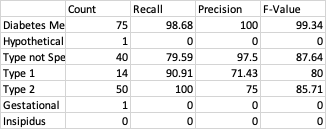

Now for the test data, and then deployment